# 프로젝트: 네이버 영화리뷰 감성분석

* 데이터셋 출처: 네이버영화리뷰(nsmc), https://github.com/e9t/nsmc
* 참고한 튜토리얼: https://wikidocs.net/44249
* label: 0(부정), 1(긍정)

## 0. 기본 셋팅 
- 시간 측정 라이브러리 설치, 랜덤시드 고정, 사용 라이브러리 import

In [1]:
# 시간 측정 
!pip install ipython-autotime
%load_ext autotime

time: 300 µs (started: 2021-01-22 10:26:24 +09:00)


In [2]:
# 사용 라이브러리
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os, random
import tensorflow as tf

time: 1.51 s (started: 2021-01-22 10:26:24 +09:00)


### Random seed 설정 
- 같은 결과를 유지하기 위해 설정해준다. 튜닝으로 개선할 수 도 있으나 기존 RNN을 사용한 사례에서 seed값을 일단 참고했다.

In [3]:
# random seed 
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
SEED = 1234
set_seeds(SEED)

time: 554 µs (started: 2021-01-22 10:26:26 +09:00)


## 1. 데이터 준비와 확인

In [4]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

time: 262 ms (started: 2021-01-22 10:26:26 +09:00)


### 1.1. 데이터 개수 확인

In [5]:
print("train set: {}개".format(len(train_data)))
print("test set: {}개".format(len(test_data)))

train set: 150000개
test set: 50000개
time: 442 µs (started: 2021-01-22 10:26:26 +09:00)


### 1.2. 상위 5개 출력
* train과 test data를 각각 살펴보면서 columns에 해당하는 데이터의 속성(특징, feature)는 어떤 것이 있는지 확인한다. 
    - 여기서 주의할 점은 이미지 분류에서 생각해보면 valid set은 전처리를 해주면 안된다라는 개념과 결측치 처리는 다르다. 이때 말하는 전처리는 데이터 증강(augmentation)이나, 밝기 변화와 같은 직접적으로 데이터에 변화를 주는 것이다. 결측치 처리는 데이터 전처리라기 보단, 데이터 정제에 해당한다. 그래서 train, test 둘다 적용해주는 것이다. => 더 알아보자

In [6]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


time: 6.74 ms (started: 2021-01-22 10:26:26 +09:00)


In [7]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


time: 6.57 ms (started: 2021-01-22 10:26:26 +09:00)


### 1.3. Label 분포  확인

<AxesSubplot:>

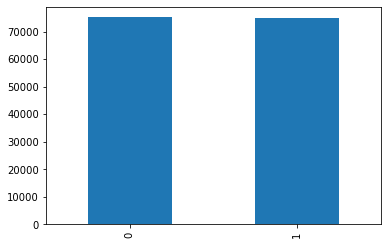

time: 117 ms (started: 2021-01-22 10:26:26 +09:00)


In [8]:
train_data['label'].value_counts().plot(kind = 'bar')

## 2. 데이터 로더 구성 
*  imdb.data_loader를 참고하면 숫자 인덱스로 변환된 텍스트와 딕셔너리를 제공한다. 가공되지 않은 nsmc 데이터셋을 데이터 전처리 해준다. 

In [9]:
# Split하기 위한 리스트 
X_train = []
X_test = []
y_train = []
y_test = []

time: 416 µs (started: 2021-01-22 10:26:26 +09:00)


### 2.1. 데이터의 중복 제거 
* data의 내용에서 중복이 되면 지워도 되는 데이터는 document열을 기준으로 할 수 있다. label은 0, 1로 분류를 하는 것이고, id는 고유할 것으로 예상되기 때문이다. 
* pandas의 unique(), value_counts() 함수는 유일한 값을 찾거나, 유일한 값별로 개수를 세준다. 
* 참고 블로그:https://rfriend.tistory.com/267

#### 중복값 확인 

In [10]:
# train 중복 개수 확인
print(len(train_data)-len(train_data['document'].value_counts()),"개")

3818 개
time: 97.4 ms (started: 2021-01-22 10:26:26 +09:00)


In [11]:
print(train_data['document'].value_counts())

굿                                               181
good                                             92
최고                                               85
쓰레기                                              79
별로                                               66
                                               ... 
볼 가치가 없는 쓰래기 영화다. 원작과 1편의 명성을 완전히 망쳤다. 볼가치없다      1
bomb는 아니다                                         1
진짜 김남주때문에 암걸리는 영화ㅡㅡ                               1
영화보는내내암걸릴뻔함                                       1
지금보기엔 촌스럽다                                        1
Name: document, Length: 146182, dtype: int64
time: 109 ms (started: 2021-01-22 10:26:26 +09:00)


In [12]:
# test 중복 개수 
print(len(test_data)-len(test_data['document'].value_counts()),"개")

843 개
time: 30.9 ms (started: 2021-01-22 10:26:26 +09:00)


In [13]:
print(test_data['document'].value_counts())

굿                                   56
good                                35
최고                                  30
tv 전기세가 아깝다!!!                      20
별로                                  20
                                    ..
이런 찝찝함이라니....                        1
좀 더 재밌게 아야기를 끌어 나갈수 있었지만 아쉬운 전개.     1
넘 재밌구여 주인공이 너무 잘생겼어요,음양사3는 없어요       1
비장함이 넘치는 영화                          1
안봤지만 낚시를 위해~                         1
Name: document, Length: 49157, dtype: int64
time: 28.1 ms (started: 2021-01-22 10:26:26 +09:00)


#### 중복 제거
* 중복을 제거하기 위해서는 내장함수를 활용하거나 pandas를 활용할 수 있다. 
    - 내장함수에는 set(순서 중요하지 않을때)을 사용하거나 for문으로 요소를 확인 후 append하는 방식을 적용할 수 있다. 
    - 참고한 자료에서는 drop_duplicates이라는 함수를 사용했다. 
* 참고 출처: https://nittaku.tistory.com/124

In [14]:
#document열을 기준으로 중복행 제거
train_data.drop_duplicates(['document'],inplace = True) #inplace = False: None 반환, True: df에 적용 

time: 41.4 ms (started: 2021-01-22 10:26:26 +09:00)


In [15]:
#document열을 기준으로 중복행 제거
test_data.drop_duplicates(['document'], inplace = True) 

time: 14.5 ms (started: 2021-01-22 10:26:27 +09:00)


In [16]:
print(len(train_data)) # 중복 개수만큼 줄어든 Train dataset: 15000 -> 146183
print(len(test_data)) # 50000 -> 49158

146183
49158
time: 521 µs (started: 2021-01-22 10:26:27 +09:00)


### 2.x. 특수문자 제외 (추가 시도)
* ㄱ ~ ㅎ: 3131 ~ 314E, ㅏ ~ ㅣ: 314F ~ 3163이며 완성형 한글의 범위는 가 ~ 힣을 사용한다. 
* 한글과 공백을 제외하고 모두 제거하는 정규화를 시도한다. 

In [17]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


time: 204 ms (started: 2021-01-22 10:26:27 +09:00)


### 2.2. NaN 결측치 제거

#### NaN(Null값) 확인 
* 확인 결과, 결측치는 없었음 
* 데이터 양이 많을 때는 비율로 보기도 하나, Null이 적게 분포할때는 0%로 분석하게 될 수 있다. 영향은 미미하지만 결측치 여부를 종합하기 위해선 sum()으로 판단하는 것이 좋다고 판단했다. 

In [18]:
# null 비율 
for col in train_data.columns:
    print('column: {:>10}\t Percent of NULL: {:.2f}%'.format(col, 
          100 * (train_data[col].isnull().sum() / train_data[col].shape[0])))

column:         id	 Percent of NULL: 0.00%
column:   document	 Percent of NULL: 0.00%
column:      label	 Percent of NULL: 0.00%
time: 9.75 ms (started: 2021-01-22 10:26:27 +09:00)


In [19]:
# null 개수
for col in train_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          train_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 1개
column:      label	 NULL value 개수: 0개
time: 8.76 ms (started: 2021-01-22 10:26:27 +09:00)


In [20]:
# null 개수
for col in test_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          test_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 1개
column:      label	 NULL value 개수: 0개
time: 3.69 ms (started: 2021-01-22 10:26:27 +09:00)


#### 결측치 제거
* 제거 말고 평균이나 0으로 넣어주는 경우가 있으나 해당 경우는 1개로 매우 적으므로 제거한다. 

In [21]:
train_data.dropna(inplace = True)

time: 14.6 ms (started: 2021-01-22 10:26:27 +09:00)


In [22]:
# null 개수
for col in train_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          train_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 0개
column:      label	 NULL value 개수: 0개
time: 9.33 ms (started: 2021-01-22 10:26:27 +09:00)


In [23]:
test_data.dropna(inplace = True)

time: 6.78 ms (started: 2021-01-22 10:26:27 +09:00)


In [24]:
# null 개수
for col in train_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          train_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 0개
column:      label	 NULL value 개수: 0개
time: 8.86 ms (started: 2021-01-22 10:26:27 +09:00)


### 2.3. 한국어 토크나이저로 토큰화
* 왜 토큰화가 필요한가? 한국어는 영어와 다르게 띄어쓰기만으로 각 형태소가 구분되지 않는다. 단어에는 조사도 있고 동사도 있어서 Mecab은 형태소 분석기고 불용어(stopwords)는 영어에서 띄어쓰기가 단어를 구분하듯이 한국어 전용 형태소 분석기이다.
* 참고 교재에서는 Okt라는 토크나이저를 쓰는데 stem 같은 정규화 기능이 있어서 과거형이나 수동/피동형들을 원래의? 날것?의 단어로 바꿔준다. e.g. 만들었다 > 만들다

* (추가시도) 불용어를 몇개 추가해보자!, 을,에서, 해서 

In [25]:
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도', '를','으로','자','에','와','한','하다','을','에서','해서']

time: 995 µs (started: 2021-01-22 10:26:27 +09:00)


* 아래 코드를 수행할 때 append하니까 오래걸리는 느낌이 들어서 예제 코드 실행해봄 

### 2.4. 불용어(Stopwords) 제거
* document열의 한 행 요소를 문장 단위로 임시 리스트에 저장한 후 train에 append한다.

In [26]:
# 10초 정도 소요
for sentence in train_data['document']:
    X_tmp = []
    X_tmp = tokenizer.morphs(sentence) # 토큰화 
    X_tmp = [word for word in X_tmp if not word in stopwords] #불용어 제거 
    X_train.append(X_tmp)

time: 10.6 s (started: 2021-01-22 10:26:27 +09:00)


In [27]:
X_train[:3]

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다']]

time: 1.59 ms (started: 2021-01-22 10:26:37 +09:00)


In [28]:
# 4초 정도 소요
for sentence in test_data['document']:
    X_tmp = []
    X_tmp = tokenizer.morphs(sentence) # 토큰화 
    X_tmp = [word for word in X_tmp if not word in stopwords] #불용어 제거 
    X_test.append(X_tmp)

time: 3.54 s (started: 2021-01-22 10:26:37 +09:00)


In [29]:
X_test[:3]

[['굳', 'ㅋ'],
 ['GDNTOPCLASSINTHECLUB'],
 ['뭐',
  '야',
  '평점',
  '.',
  '...',
  '나쁘',
  '진',
  '않',
  '지만',
  '10',
  '점',
  '짜리',
  '더더욱',
  '아니',
  '잖아']]

time: 1.6 ms (started: 2021-01-22 10:26:41 +09:00)


### 2.5. 사전(vocab) word_to_index 구성
* 다양한 Tokenizer를 활용해서 데이터를 분석하기 위해 문자 데이터를 숫자로 바꿔줘야한다. 
* Counter를 사용해도 되고, okt Tokenizer로 fit_on_texts를 사용해도 정수 인코딩을 할 수 있다.
* word_to_index는 사전의 크기를 결정하는 인자이다. 따라서 words가 몇개 정도 있는지 보고 그에 따라 사전의 크기를 결정해주면 된다. 

In [30]:
words = np.concatenate(X_train).tolist()
len(words)

1965664

time: 604 ms (started: 2021-01-22 10:26:41 +09:00)


### 사전 크기 설정 
* 사전 크기 또한 조절할 수 있는 부분이다. 하지만 너무 크게하면 학습이 느려진다. 

In [31]:
# 사전 크기 설정
vocab_size = 43800
counter = Counter(words)
counter = counter.most_common(vocab_size-4)
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]

word_to_index = {word:index for index, word in enumerate(vocab)}

time: 287 ms (started: 2021-01-22 10:26:42 +09:00)


In [32]:
type(word_to_index)

dict

time: 1.66 ms (started: 2021-01-22 10:26:42 +09:00)


In [33]:
len(word_to_index)

43800

time: 1.4 ms (started: 2021-01-22 10:26:42 +09:00)


In [34]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '영화': 4,
 '다': 5,
 '고': 6,
 '하': 7,
 '보': 8,
 '게': 9,
 '지': 10,
 '있': 11,
 '없': 12,
 '좋': 13,
 '나': 14,
 '었': 15,
 '만': 16,
 '는데': 17,
 '너무': 18,
 '봤': 19,
 '적': 20,
 '안': 21,
 '정말': 22,
 '로': 23,
 '것': 24,
 '음': 25,
 '아': 26,
 '네요': 27,
 '어': 28,
 '재밌': 29,
 '지만': 30,
 '같': 31,
 '진짜': 32,
 '했': 33,
 '기': 34,
 '네': 35,
 '않': 36,
 '점': 37,
 '거': 38,
 '았': 39,
 '수': 40,
 '되': 41,
 '면': 42,
 'ㅋㅋ': 43,
 '인': 44,
 '말': 45,
 '연기': 46,
 '주': 47,
 '최고': 48,
 '내': 49,
 '평점': 50,
 '이런': 51,
 '던': 52,
 '어요': 53,
 '할': 54,
 '왜': 55,
 '겠': 56,
 '스토리': 57,
 '해': 58,
 'ㅋㅋㅋ': 59,
 '습니다': 60,
 '듯': 61,
 '아니': 62,
 '드라마': 63,
 '생각': 64,
 '더': 65,
 '그': 66,
 '싶': 67,
 '사람': 68,
 '때': 69,
 '감동': 70,
 '배우': 71,
 '함': 72,
 '본': 73,
 '까지': 74,
 '뭐': 75,
 '알': 76,
 '만들': 77,
 '내용': 78,
 '볼': 79,
 '보다': 80,
 '감독': 81,
 '라': 82,
 '재미': 83,
 '그냥': 84,
 '시간': 85,
 '지루': 86,
 '중': 87,
 '재미있': 88,
 '였': 89,
 '잼': 90,
 '년': 91,
 '사랑': 92,
 '못': 93,
 '재미없': 94,


time: 23.4 ms (started: 2021-01-22 10:26:42 +09:00)


* word_to_index는 key값이 텍스트 스트링이다. 따라서 인덱스 역할을 하는 key값을 숫자이기 때문에 해당 값에서 숫자를 추출하기 위한 함수가 필요하다. => wordlist_to_indexlist

In [35]:
word_to_index['재미']

83

time: 1.39 ms (started: 2021-01-22 10:26:42 +09:00)


### 2.6. 텍스트 스트링을 사전 인덱스 스트링으로 변환

In [36]:
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

time: 506 µs (started: 2021-01-22 10:26:42 +09:00)


In [37]:
wordlist_to_indexlist({'재미':85})

[83]

time: 1.39 ms (started: 2021-01-22 10:26:42 +09:00)


In [38]:
X_train[0]

['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리']

time: 1.61 ms (started: 2021-01-22 10:26:42 +09:00)


### 2.7. X_train, y_train, X_test, y_test

In [39]:
X_train = list(map(wordlist_to_indexlist, X_train))
X_test = list(map(wordlist_to_indexlist, X_test))

time: 960 ms (started: 2021-01-22 10:26:42 +09:00)


In [40]:
X_train[:3]

[[26, 65, 892, 32, 211, 14, 27, 696],
 [974, 478, 488, 633, 4, 108, 1551, 46, 863, 946, 10, 36, 361],
 [18, 189, 28634]]

time: 1.87 ms (started: 2021-01-22 10:26:43 +09:00)


In [41]:
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

time: 29.8 ms (started: 2021-01-22 10:26:43 +09:00)


#### index to word

In [42]:
index_to_word = {index:word for word, index in word_to_index.items()}

time: 6.14 ms (started: 2021-01-22 10:26:43 +09:00)


In [43]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

time: 692 µs (started: 2021-01-22 10:26:43 +09:00)


## 3. 모델 구성을 위한 데이터 분석 및 가공

### 데이터셋 내 문장 길이 분포 

In [44]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[26, 65, 892, 32, 211, 14, 27, 696]
라벨:  0
1번째 리뷰 문장 길이:  8
2번째 리뷰 문장 길이:  13
time: 897 µs (started: 2021-01-22 10:26:43 +09:00)


In [45]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  14.002897526863554
문장길이 최대 :  105
문장길이 표준편차 :  11.58026473323271
time: 28 ms (started: 2021-01-22 10:26:43 +09:00)


### 적절한 문장 최대 길이 지정 
* 분포를 통해 확인했을 때 문장의 최대 길이는 40정도가 적당해 보인다. 
* 추가 시도인 2.x.에서 특수문자를 지워주고 나니까 문장의 최대길이와 평균 길이가 줄었다.

리뷰의 최대 길이 : 105
리뷰의 평균 길이 : 14.002897526863554


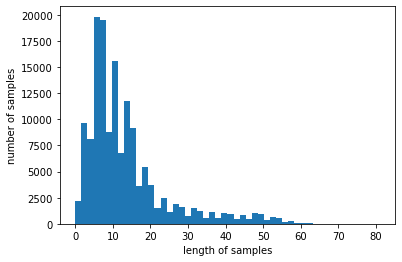

time: 576 ms (started: 2021-01-22 10:26:43 +09:00)


In [46]:
print('리뷰의 최대 길이 :', np.max(num_tokens))
print('리뷰의 평균 길이 :', np.mean(num_tokens))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* 분포와 비슷한 계산수치를 사용해도 41 정도가 최대 길이로 보이고, 90%이상을 포함하므로 최대 길이를 41이다. 
* 특수문자 처리와 불용어를 추가준 후에는 37이 나왔다. padding은 37에 맞춰주도록 한다.

In [47]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_len = int(max_tokens)
print('pad_sequences maxlen : ', max_len)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  37
전체 문장의 0.9363823916371027%가 maxlen 설정값 이내에 포함됩니다. 
time: 2.11 ms (started: 2021-01-22 10:26:44 +09:00)


### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

* 왜 padding을 해주는가? 자연어 처리에서 입력 데이터인 문장은 서로 길이가 다를 수 있다. 따라서, 문장의 길이를 어느 정도의 기준을 가지고 임의로 동일하게 맞춰주는 작업이 필요하다. 

In [48]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, 
                        maxlen = max_len,
                        value=word_to_index["<PAD>"],
                        padding='pre')
X_test = pad_sequences(X_test, 
                       maxlen = max_len,
                       value=word_to_index["<PAD>"],
                       padding='pre')

time: 737 ms (started: 2021-01-22 10:26:44 +09:00)


* 최대 길이에 맞춰 shape가 일괄적으로 맞춰졌음을 확인했다. 

In [49]:
# 데이터셋 정제 후 데이터셋 shape 확인
print(X_train.shape)
print(X_test.shape)

(146182, 37)
(49157, 37)
time: 395 µs (started: 2021-01-22 10:26:44 +09:00)


## 4. 모델 구성 및 Validation set 구성 

### 4.1. 모델 구성 

### 단어 집합(vocab size) 계산

In [50]:
total_cnt = len(word_to_index)  # 어휘 사전의 크기입니다

print(total_cnt, '개')

43800 개
time: 448 µs (started: 2021-01-22 10:26:44 +09:00)


In [51]:
word_vector_dim = 200  
# 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)
#  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 
# 이후 사용되는 ko의 차원수에 맞춰준다. 

time: 246 µs (started: 2021-01-22 10:26:44 +09:00)


* LSTM 모델 구성
    - 기존에 차원 8에서 64로 높임

In [52]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 64로 하였습니다. (변경가능)
# model.add(keras.layers.Dense(8, activation='relu')) # 안해도 됨
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         8760000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 8,928,577
Trainable params: 8,928,577
Non-trainable params: 0
_________________________________________________________________
time: 647 ms (started: 2021-01-22 10:26:44 +09:00)


### 4.2. 데이터셋 분리
* 테스트가 약 15000여개가 있으므로 4:1 비율로 Valid를 할당한다. 
* 따라서 valid set은 전체 train set에서 약 20%에 해당하는 29300만건 정도 할당한다

In [53]:
print(X_train.shape[0]*0.2)

29236.4
time: 384 µs (started: 2021-01-22 10:26:45 +09:00)


In [54]:
# validation set 29300건 분리
X_val = X_train[:29300]   
y_val = y_train[:29300]

# validation set을 제외한 나머지 
partial_X_train = X_train[29300:]  
partial_y_train = y_train[29300:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116882, 37)
(116882,)
time: 585 µs (started: 2021-01-22 10:26:45 +09:00)


## 5. 모델 훈련 개시 
* 최고 점수 나오는 모델을 저장할 수 있도록 함 (추가 시도)

In [55]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

time: 440 µs (started: 2021-01-22 10:26:45 +09:00)


* batch size는 얼마만큼 묶음지어서 학습시킬 것이냐이기 때문에 512는 너무 커서 100정도로 줄여서 시도했다. 값은 일반적으로 60, 80정도 잡길래 일단 100으로 줄였다.(추가 시도)

In [56]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=60, # 512, 100, 60 
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
1949/1949 [==============================] - 167s 86ms/step - loss: 0.3817 - accuracy: 0.8269 - val_loss: 0.3342 - val_accuracy: 0.8517
Epoch 2/20
1949/1949 [==============================] - 166s 85ms/step - loss: 0.2705 - accuracy: 0.8872 - val_loss: 0.3333 - val_accuracy: 0.8578
Epoch 3/20
1949/1949 [==============================] - 168s 86ms/step - loss: 0.2030 - accuracy: 0.9178 - val_loss: 0.3674 - val_accuracy: 0.8502
Epoch 4/20
1949/1949 [==============================] - 169s 87ms/step - loss: 0.1519 - accuracy: 0.9403 - val_loss: 0.4408 - val_accuracy: 0.8492
Epoch 5/20
1949/1949 [==============================] - 168s 86ms/step - loss: 0.1151 - accuracy: 0.9550 - val_loss: 0.5072 - val_accuracy: 0.8456
Epoch 6/20
1949/1949 [==============================] - 168s 86ms/step - loss: 0.0883 - accuracy: 0.9659 - val_loss: 0.5764 - val_accuracy: 0.8397
Epoch 7/20
1949/1949 [==============================] - 172s 88ms/step - loss: 0.0713 - accuracy: 0.9726 - val_loss: 0

## 6. Loss, Accuracy 그래프 시각화

In [57]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6497 - accuracy: 0.8261
[0.6497150659561157, 0.8261488676071167]
time: 3.1 s (started: 2021-01-22 10:46:26 +09:00)


In [58]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 541 µs (started: 2021-01-22 10:46:29 +09:00)


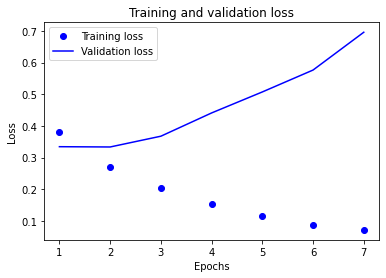

time: 143 ms (started: 2021-01-22 10:46:29 +09:00)


In [59]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

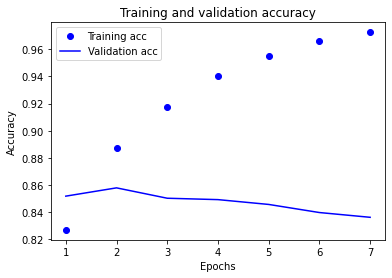

time: 131 ms (started: 2021-01-22 10:46:29 +09:00)


In [60]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* 팀원들과 학습결과를 공유했을 때 내 그래프가 매우 이상한 편이었다. 과적합이 에폭 2에서부터 뜬다.. .ㅠ
* 파라미터를 바꿔줘보기도 했지만 동일하게 과적합이 돼서 이유를 명확히 파악하지 못 했다. 

## 7. 학습된 Embedding 레이어 분석

In [61]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(43800, 200)
time: 46.3 ms (started: 2021-01-22 10:46:30 +09:00)


In [62]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

time: 4.84 s (started: 2021-01-22 10:46:30 +09:00)


## 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [63]:
from gensim.models import Word2Vec
import os

# 한국어 Word2Vec 사용
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

print(word2vec)

Word2Vec(vocab=30185, size=200, alpha=0.025)
time: 540 ms (started: 2021-01-22 10:46:34 +09:00)


In [64]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

time: 205 ms (started: 2021-01-22 10:46:35 +09:00)


/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### 8.1. CNN에 임베딩벡터를 적용 

In [66]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_len, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_cnn.add(keras.layers.Conv1D(16, 5, activation='relu')) #16, 32 (추가시도)
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 5, activation='relu')) #negative error가 떠서 커널 사이즈를 줄여줬다. (추가 시도)
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(16, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid')) 

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 37, 200)           8760000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 33, 16)            16016     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 16)             1296      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

### 8.2. LSTM에 임베딩 벡터 적용 

In [72]:
from tensorflow.keras.initializers import Constant

model_transfer = keras.Sequential()
model_transfer.add(keras.layers.Embedding(vocab_size, 
                   word_vector_dim, 
                   embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                   input_length=max_len, 
                   trainable=True))
model_transfer.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 64로 하였습니다. (변경가능)
model_transfer.add(keras.layers.Dense(8, activation='relu')) # 안해도 됨
model_transfer.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_transfer.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 37, 200)           8760000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 8,929,489
Trainable params: 8,929,489
Non-trainable params: 0
_________________________________________________________________
time: 232 ms (started: 2021-01-22 10:51:58 +09:00)


### 8.3. GlobalMaxPooling1D() 레이어 하나만 사용

In [73]:
model_maxpool = keras.Sequential()
model_maxpool.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_maxpool.add(keras.layers.GlobalMaxPooling1D())
model_maxpool.add(keras.layers.Dense(8, activation='relu'))
model_maxpool.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_maxpool.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         8760000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 8,761,617
Trainable params: 8,761,617
Non-trainable params: 0
_________________________________________________________________
time: 55.9 ms (started: 2021-01-22 10:52:00 +09:00)


In [74]:
# 학습의 진행
model_transfer.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15

history = model_transfer.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=100,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
1169/1169 [==============================] - 102s 88ms/step - loss: 0.4094 - accuracy: 0.8086 - val_loss: 0.3400 - val_accuracy: 0.8489
Epoch 2/15
1169/1169 [==============================] - 102s 87ms/step - loss: 0.2907 - accuracy: 0.8775 - val_loss: 0.3386 - val_accuracy: 0.8567
Epoch 3/15
1169/1169 [==============================] - 103s 88ms/step - loss: 0.2313 - accuracy: 0.9055 - val_loss: 0.3380 - val_accuracy: 0.8597
Epoch 4/15
1169/1169 [==============================] - 103s 88ms/step - loss: 0.1824 - accuracy: 0.9278 - val_loss: 0.3811 - val_accuracy: 0.8562
Epoch 5/15
1169/1169 [==============================] - 103s 88ms/step - loss: 0.1386 - accuracy: 0.9470 - val_loss: 0.4361 - val_accuracy: 0.8544
Epoch 6/15
 212/1169 [====>.........................] - ETA: 1:23 - loss: 0.0980 - accuracy: 0.9631

KeyboardInterrupt: 

time: 8min 54s (started: 2021-01-22 10:52:00 +09:00)


* 전이학습하기 전 모델보다 성능이 약 1% 정도 올랐다. 

In [75]:
# 테스트셋을 통한 모델 평가
results = model_transfer.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4823 - accuracy: 0.8371
[0.4822773337364197, 0.8370527029037476]
time: 3.56 s (started: 2021-01-22 11:00:58 +09:00)


In [76]:
embedding_layer = model_transfer.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(43800, 200)
time: 57.8 ms (started: 2021-01-22 11:01:04 +09:00)


In [77]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_transfer_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_transfer.txt'
f = open(word2vec_transfer_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors_transfer = model_transfer.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_transfer[i, :])))))
f.close()

time: 4.55 s (started: 2021-01-22 11:01:05 +09:00)


## 10. 루브릭 및 회고

### 10.1. 루브릭
* 3가지 이상의 모델이 성공적으로 시도됨
    - cnn, maxpooling, lstm 세가지의 모델을 모두 수행했으며 lstm을 위주로 정확도 평가를 진행했습니다. 
    
* gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

* 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

#### 단어간 유사단어 찾기 
* 결과로만 보면 가중치를 가져와서 한 것 보다는 전이학습이 좋다라고는 보기 어렵긴하다, 직관적으로 비교했을때의 단어는 유ㅏ사한 단어들이 더 많이 보이는거 같지만 그 기준이 되는 퍼센트값이 별로 높지 않았다. 

In [84]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, limit=1000000)

time: 6.12 s (started: 2021-01-22 11:08:04 +09:00)


In [88]:
word2vec.similar_by_word("재미")

[('색다른', 0.7083466053009033),
 ('매우', 0.6988797187805176),
 ('박민우', 0.6799376010894775),
 ('파라', 0.6796845197677612),
 ('아들', 0.6792794466018677),
 ('꼬맹이', 0.6650020480155945),
 ('두고두고', 0.6644453406333923),
 ('엄청나', 0.6618524789810181),
 ('헌데', 0.6610073447227478),
 ('졸라', 0.6519945859909058)]

time: 7.55 ms (started: 2021-01-22 11:09:51 +09:00)


In [90]:
word2vec_transfer_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_transfer.txt'
word2vec = KeyedVectors.load_word2vec_format(word2vec_transfer_file_path, limit=1000000)

time: 6.3 s (started: 2021-01-22 11:10:09 +09:00)


In [91]:
word2vec.similar_by_word("재미")

[('취미', 0.5691553354263306),
 ('매력', 0.539165735244751),
 ('흥미', 0.5072970986366272),
 ('유머', 0.5018364191055298),
 ('정취', 0.4981369078159332),
 ('향수', 0.4903198480606079),
 ('글쓰기', 0.47742536664009094),
 ('즐거움', 0.4740073084831238),
 ('비애', 0.46634796261787415),
 ('외모', 0.46372294425964355)]

time: 29.9 ms (started: 2021-01-22 11:10:15 +09:00)


#### 정확도
* 결과적으로는 전이학습의 정확도가 더 높게는 나왔으나, 흠.. 1%정도로 개선되었다고는 보기 어렵다. 예제처럼 5%정도 개선되지는 않았다. 일단 풀러닝만 확인했을때는 오버피팅되는 문제를 해결하지 못한 점도 있어서 전체적으로 정확도가 낮게 나온듯 하다. 
    - 풀러닝: 0.8261488676071167
    - 전이학습: 0.8370527029037476
    

### 10.2. 회고
* 어려웠던 점: 자연어처리를 처음 접하다 보니, 형태소를 기준으로 단어를 쪼개는 과정은 이해가 잘 됬지만 임베딩하는 부분은 이해하는데 시간이 좀 걸렸다. 

* 시도: 특수기호 제거와 불용어 추가, 생각보다 정확도가 처음에 시도했을때는 82%가 나오고 전이학습이 오히려 높지 않았다. 
    - 문제점: 전이학습할때 한국어 WordVec으로 학습된 모델을 pre trained model로 사용헀어야했는데 예제 그대로 따라가다가 영어를 썼다. ㅎㅎ 
             중간에 패키지 설치 오류가 떠서 블로그에 정리해뒀다.   
             https://vg-rlo.tistory.com/44


* 기타..? 모델 학습에 시간이 걸리다 보니 autotime 라이브러리를 활용해서 시간을 측정해두고 해당 모델 학습의 예상 소요 시간에 따라 모델 훈련 되는 동안 다른 일을 할 수 있어졌다..!
